In [1]:
# method for finding peaks of multiple velocity signals
import matplotlib.pyplot as plt
import glob
import numpy as np
import scipy
from scipy import signal
from scipy.signal import find_peaks
import scipy.fftpack

In [2]:
# define data class
class SubjectData:

    def __init__(self, name: str, data: np.ndarray, samp: int):
        self.name = name    # name of file
        self.data = data    # time series
        self.samp = samp    # sample rate
        self.Ts = 1/self.samp
        self.N = len(self.data)
        self.t = np.linspace(0,self.N*self.Ts,self.N)   # time axis (seconds)

    # method: given a filtering impulse response, store filtered time series
    def filter(self, impResp: np.ndarray):
        self.y = np.convolve(self.data,impResp,'same')

In [3]:
# load files into object list
# get list of filenames
myFiles = sorted(glob.glob('*.txt'))
# given data sample rate
fs = 128

# populate object list
data = []
for item in myFiles:
    name = item.rsplit('.',1)[0]
    data.append(SubjectData(name, np.loadtxt(item), fs))

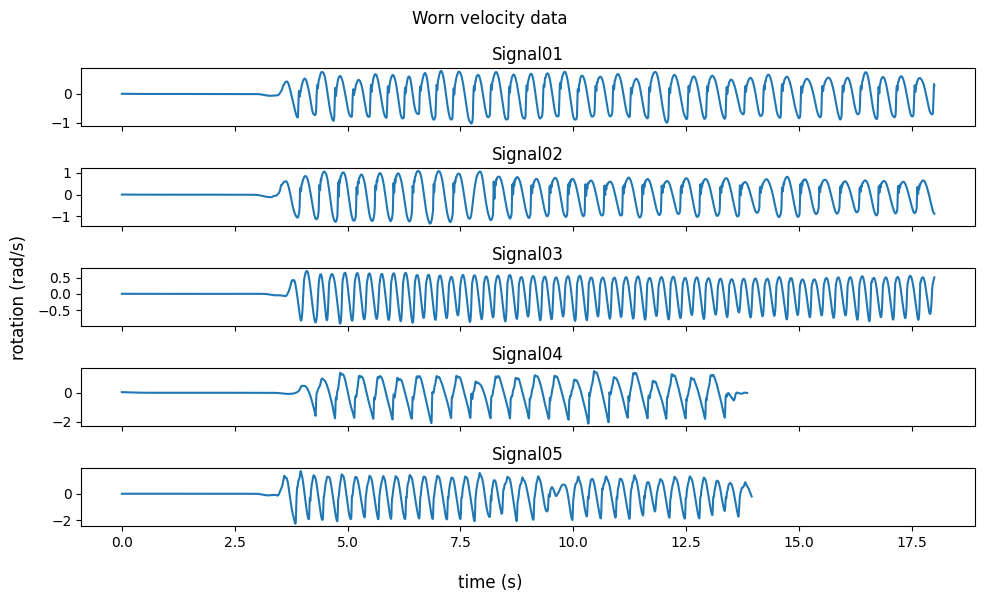

Signals are too noisy for accurate peak detection


In [4]:
# plot raw data
fig, axs = plt.subplots(5,1,figsize=(10, 6), sharex=True)
for set,ax in zip(data,axs):
    ax.plot(set.t,set.data)
    ax.set_title(set.name)

# show plots
fig.suptitle('Worn velocity data')
fig.supxlabel('time (s)')
fig.supylabel('rotation (rad/s)')
fig.tight_layout()
plt.show()

print('Signals are too noisy for accurate peak detection')

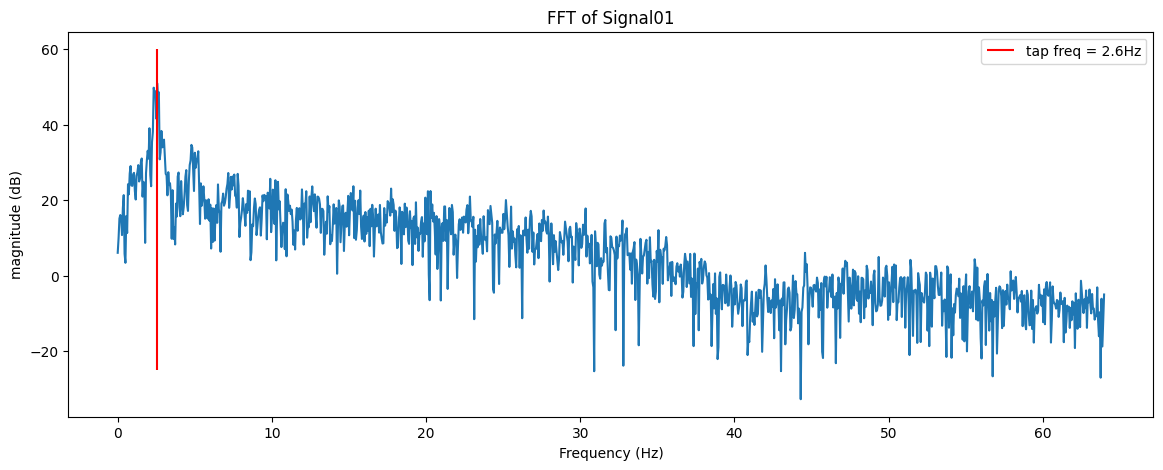

In [5]:
# select tapping frequency by checking fft of signal 01
N = data[0].N
X1 = scipy.fft.fft(data[0].data[:N])
X_mag = np.absolute(X1)         # spectral magnitude
maxF = np.argmax(X_mag)         # peak freq
f = np.linspace(0, fs, N)       # frequency variable

plt.figure(figsize=(14, 5))
plt.title('FFT of Signal01')
plt.plot(f[:int(N/2)], 20*np.log10(X_mag[:int(N/2)])) # magnitude spectrum
plt.xlabel('Frequency (Hz)')
plt.ylabel('magnitude (dB)')
# plot line at max frequency
plt.vlines(f[maxF],-25,60,colors='r',label=f'tap freq = {f[maxF]:.1f}Hz')
plt.legend()

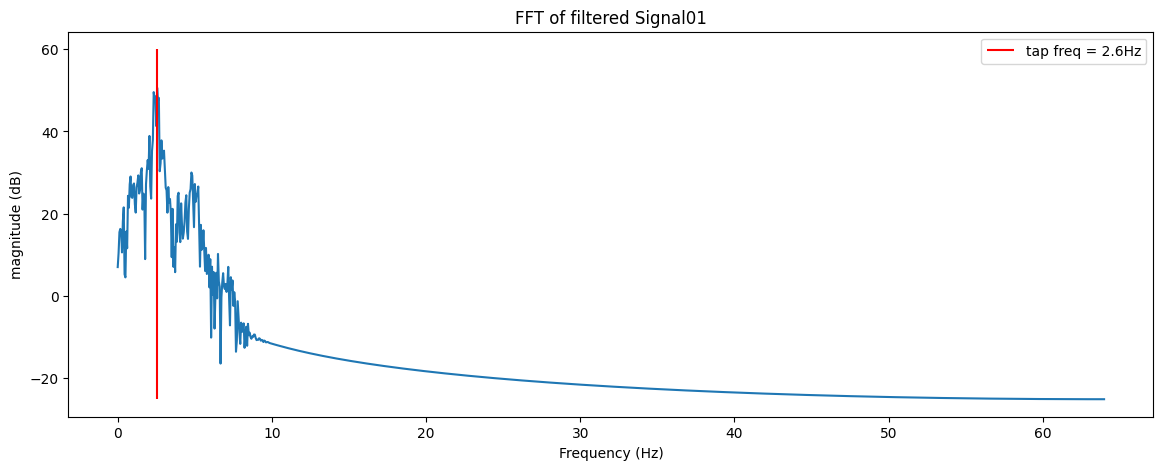

In [6]:
# filter signals using a lowpass filter at 2 * maxF
f0 = 2 * f[maxF]
h = signal.firwin(101,cutoff=f0,width=11,window='hamming',pass_zero='lowpass',fs=fs)

for set in data:
    set.filter(h)

# plot fft of filtered signal01 for comparison
y1 = data[0].y
X1f = scipy.fft.fft(y1[:N])
X_mag = np.absolute(X1f)        # spectral magnitude
maxF = np.argmax(X_mag)         # peak freq
f = np.linspace(0, fs, N)       # frequency variable
plt.figure(figsize=(14, 5))
plt.title('FFT of filtered Signal01')
plt.plot(f[:int(N/2)], 20*np.log10(X_mag[:int(N/2)])) # magnitude spectrum
plt.xlabel('Frequency (Hz)')
plt.ylabel('magnitude (dB)')
# plot line at max frequency
plt.vlines(f[maxF],-25,60,colors='r',label=f'tap freq = {f[maxF]:.1f}Hz')
plt.legend()

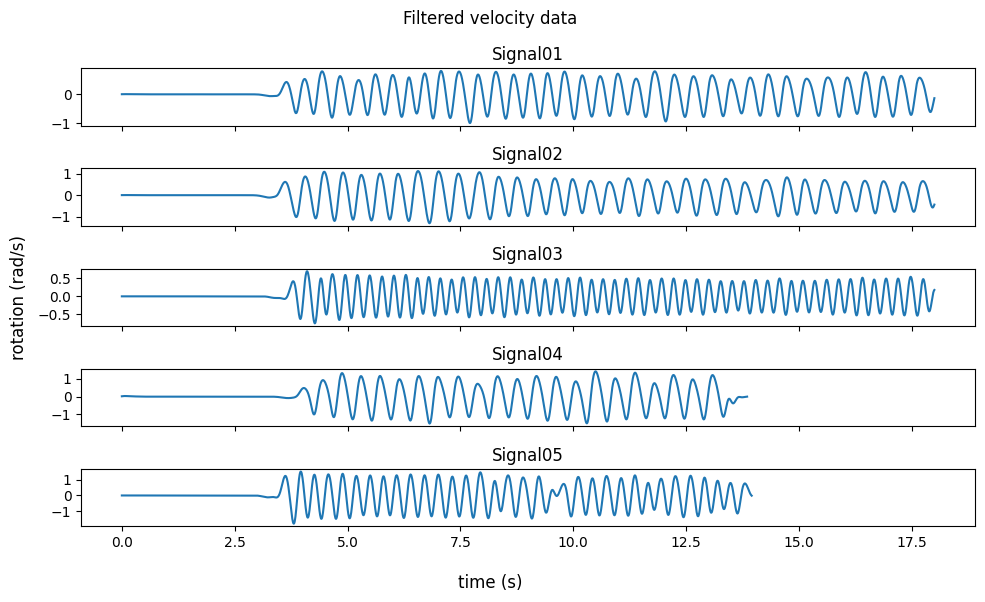

In [7]:
# plot filtered data
fig, axs = plt.subplots(5,1,figsize=(10, 6), sharex=True)
for set,ax in zip(data,axs):
    ax.plot(set.t,set.y)
    ax.set_title(set.name)

# show plots
fig.suptitle('Filtered velocity data')
fig.supxlabel('time (s)')
fig.supylabel('rotation (rad/s)')
fig.tight_layout()
plt.show()

Text(0, 0.5, 'freq')

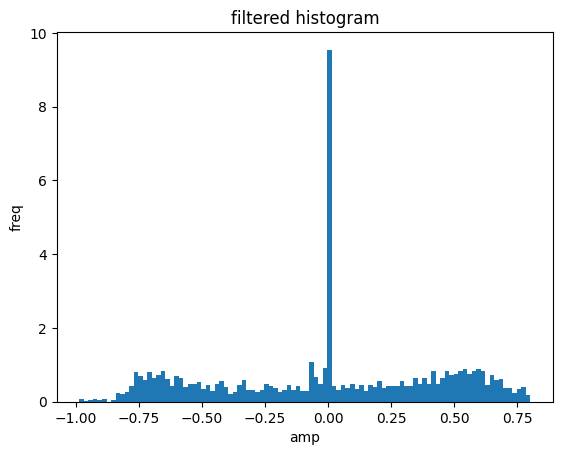

In [8]:
# find threshold
set = data[0]
hist_filt = plt.hist(set.y,bins=100,density=True,stacked=True)

plt.figure(1,1)
plt.title('filtered histogram')
plt.xlabel('amp')
plt.ylabel('freq')
#plt.vlines([-.2,.2],0,5,colors='red')

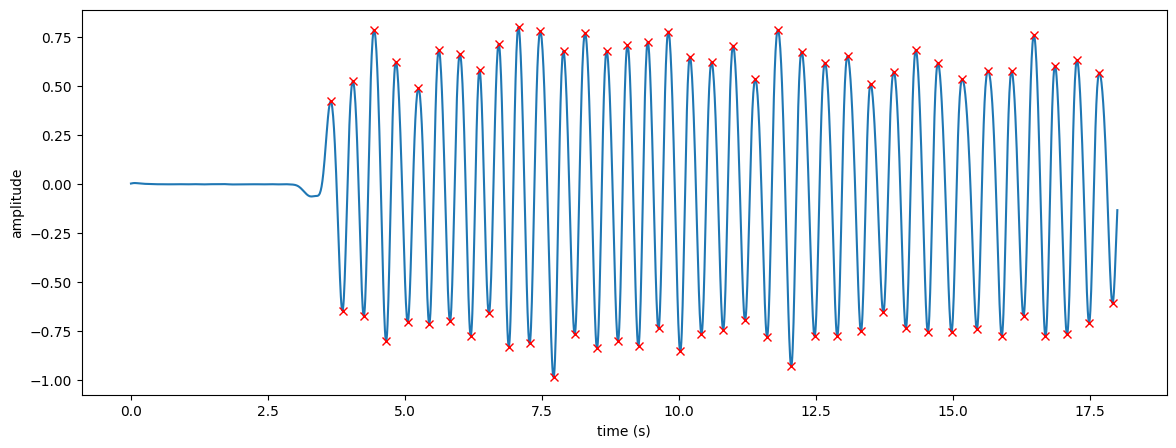

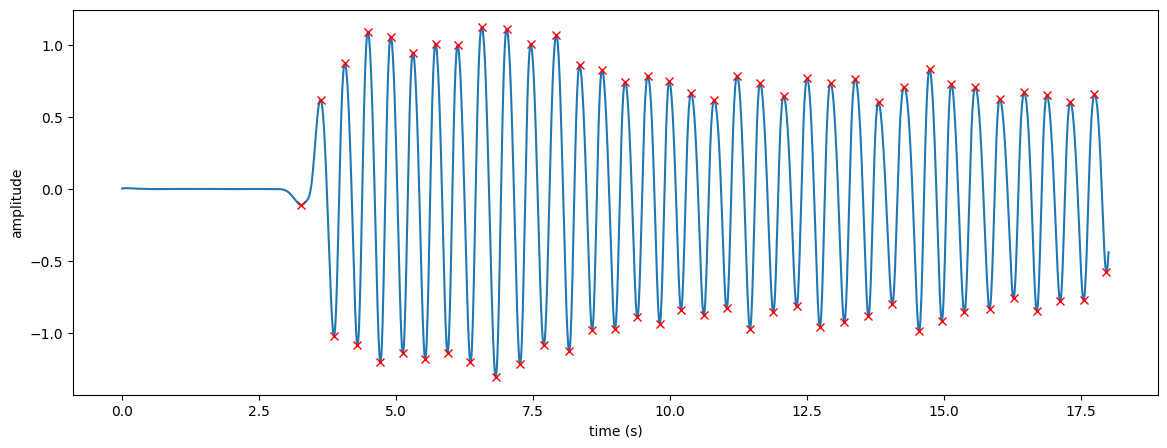

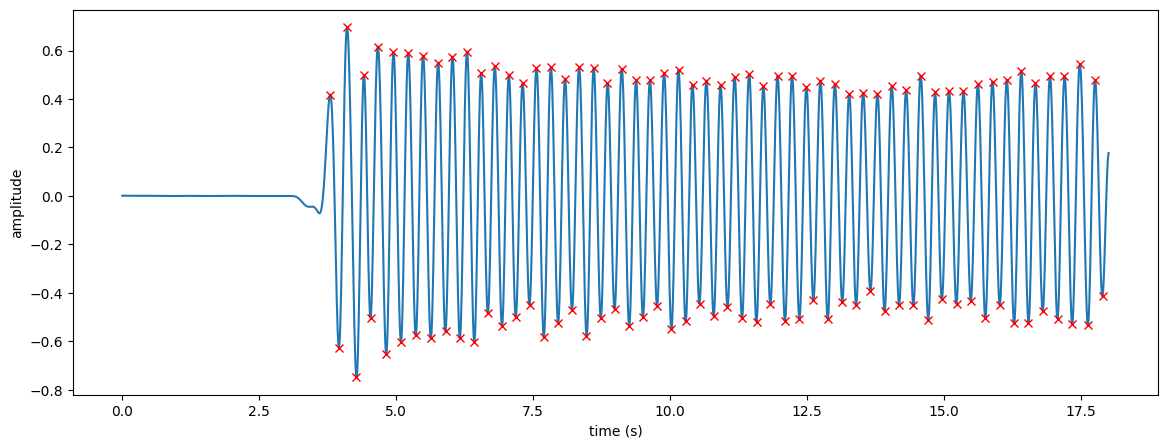

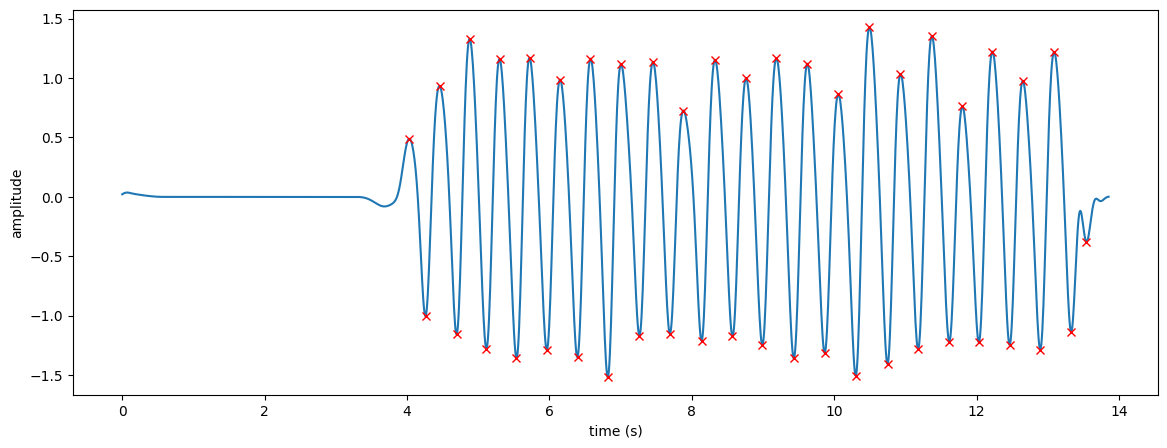

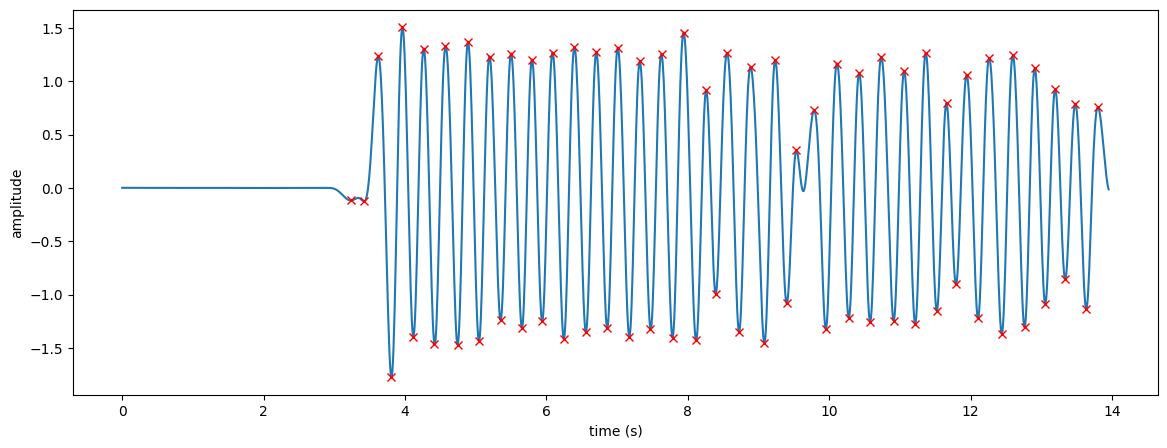

In [9]:
# find min/max
thresh = 0.1

for set in data:
    peaks, _ = find_peaks(abs(set.y), height=thresh, distance=10)

    # plot peaks
    fig = plt.figure(figsize=(14,5))
    plt.plot(set.t,set.y)
    plt.plot(set.t[peaks], set.y[peaks], "rx")
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    plt.show()